In [328]:
import pandas as pd
import numpy as np
import math
from scipy.stats import describe, randint
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import scipy.sparse
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression

sns.set()

# Methods for exporting tables and images to latex
def saveimg(filename, fig):
    file_path = os.path.join(os.getcwd(), 'images')
    os.makedirs(file_path, exist_ok=True)
    fig.savefig(os.path.join(file_path, filename))
    
def savetable(filename, df):
    file_path = os.path.join(os.getcwd(), 'tables')
    os.makedirs(file_path, exist_ok=True)
    pd.DataFrame(df).to_latex(os.path.join(file_path, filename),escape = False, index = False)
    
val = [1,4,12,36,100,284,780,2172,5916,16268,44100,120292,324932,881500,2374444,6416596,17245332,46466676,124658732,335116620,897697164,2408806028,6444560484,17266613812,46146397316,123481354908,329712786220,881317491628]

# 3.

In [421]:
def random_neighbour(points):

    # Getting dimensions of points
    dimension = np.shape(points)
    
    # Generate if going up or down, do this for all points
    up_or_down = 2*np.random.randint(2, size=dimension[0]) - 1
    
    # Generate which diretion to go in for all points
    direction = np.random.randint(dimension[1], size=dimension[0])
    
    # Create new matrix, create a binary matrix of the direction
    indptr = range(len(direction)+1)
    data = np.ones(len(direction))
    points_to_change = scipy.sparse.csr_matrix((data, direction, indptr)).toarray()
    
    # Add the binary matrix multiplied by direction to the old points
    new_points = points + (points_to_change.T*up_or_down).T
    
    # Generating probabilities
    probabilities = np.ones(dimension[0])*1/(dimension[1]*2)
    
    return new_points, probabilities

def random_neighbour_avoiding(random_walks):
    
    # Start by swapping axis i and k so it is possible to iterate over all random walks
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    new_points = []
    probabilities = []
    
    # Iterate over random walks
    for random_walk in random_walks_list:
        
        random_walk = random_walk.tolist()
        
        last_point = random_walk[-1]
        viable_points = []
        
        dimension = np.shape(last_point)[0]
        
        for n in range(dimension):
            
            change = np.zeros(dimension)
            change[n] = 1
            
            point_up = last_point - change
            point_down = last_point + change
            
            viable_points.append(list(point_up))
            viable_points.append(list(point_down))
        
        viable_points = list(filter(lambda x: x not in random_walk, viable_points))
        length = len(viable_points)
                        
        if length == 0:
            new_points.append(last_point)
            probabilities.append(0)
        else:   
            probabilities.append(1/length)
            new_point_index = np.random.randint(length, size=1)[0]
            new_points.append(viable_points[new_point_index])
        
    return new_points, probabilities

def is_self_avoiding(random_walk):
    return int(len(np.unique(random_walk, axis=0)) == len(random_walk))

def generate_weights(random_walks, weights, probabilities, do_resample=False):
    
    # Get indexes where weights is different from zero
    indexes = np.intersect1d(np.nonzero(weights)[0], np.nonzero(probabilities)[0])
    
    # Create new weights
    new_weights = np.zeros(len(weights))
    
    # Start by swapping axis i and k so it is possible to iterate over all random walks
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    # Looping over wieghts different from zero
    for index in indexes:
        if(do_resample):
            new_weights[index] = is_self_avoiding(random_walks_list[index])/probabilities[index]
        else:
            new_weights[index] = is_self_avoiding(random_walks_list[index])/probabilities[index]*weights[index]
        
    return new_weights      

def resample(random_walks, weights):
    
    probabilities = weights/np.sum(weights)
    random_walks_list = np.swapaxes(random_walks, 0, 1)
    
    replacement_index = np.random.choice(np.arange(len(random_walks_list)), len(random_walks_list), p = probabilities)
    
    resamples_random_walks = list(map(lambda x: random_walks_list[x], replacement_index))
    
    weights = np.ones(len(weights))
    
    return np.swapaxes(resamples_random_walks, 0, 1).tolist()

def init_walk (d, k, N, self_avoiding = False, do_resample = False):
    
    # The random_walk array has the following structure compared 
    # to the lecture notes random_walk[k][i][d], where:
    # k = step number k
    # i = simulation number
    # d = dimension 
    
    random_walks = []
    weights = [[1] * N]
    
    random_walks.append(np.zeros((N, d)))
    
    for step in range(k):
                        
        if do_resample:
            random_walks = resample(random_walks, weights[-1])
        
        if self_avoiding:
            step_all, probabilities = random_neighbour_avoiding(random_walks)
        else:
            step_all, probabilities = random_neighbour(random_walks[step])
            
        random_walks.append(step_all)
        weights.append(generate_weights(random_walks, weights[step], probabilities, do_resample=do_resample))
           
            
        print("-", end="")
        
    return random_walks, weights

def estimate_parameters(weights, start_index = 1):
    
    # Calculate mean
    cn = np.mean(weights[start_index:], axis=1)
    length = len(cn)
    
    # Finding optimal parameters
    y = np.log(cn)
    #plt.plot(y)
    X = np.hstack((np.ones(length), np.arange(length)+start_index, np.log(np.arange(length)+start_index))).reshape(3,length).T

    theta =(np.linalg.inv(X.T@X)@X.T)@y

    # adding 1
    theta = [np.e**theta[0], np.e**theta[1], theta[2] + 1]
    
    return theta 

In [395]:
walks, weights = init_walk(2, 20, 1000, self_avoiding=True, do_resample=True)

cn = np.mean(weights, axis=1)

--------------------

Dimension: 1
--------------------[1.0, 1.0, 1.0]
Dimension: 2
--------------------[3.0989593294785864, 0.9956297274441137, 0.9569697160078945]
Dimension: 3
--------------------[4.929935002236777, 0.9997792966505662, 0.987606209312221]
Dimension: 4
------------

KeyboardInterrupt: 

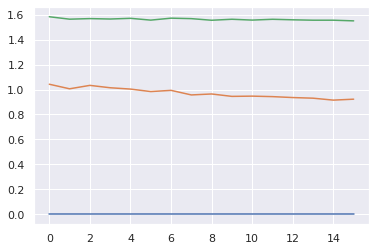

In [373]:
for d in range(1,10):
    print(f'Dimension: {d}')
    walks, weights = init_walk(d, 20, 10**3, self_avoiding=True, do_resample=True)
    print(estimate_parameters(weights, start_index = 5))

In [ ]:
walks, weights = init_walk(2, 20, 10**4, self_avoiding=True, do_resample=True)

print(estimate_parameters(weights))
cn = np.mean(weights, axis = 1)
cn = np.cumprod(cn)
plt.plot(cn - val[:21]/val[:21]*100)



array([1.00000000e+00, 4.00000000e+00, 1.20000000e+01, 3.60000000e+01,
       9.98640000e+01, 2.84312808e+02, 7.79585720e+02, 2.16179120e+03,
       5.88007206e+03, 1.62172388e+04, 4.35595033e+04, 1.17654218e+05,
       3.16725156e+05, 8.47239792e+05, 2.20536518e+06, 5.80672652e+06,
       1.51787831e+07, 3.92978695e+07, 1.00366759e+08, 2.51017263e+08,
       6.17000433e+08])

In [417]:
np.array(val[:21]) - np.array(cn)

array([ 0.00000000e+00,  3.00000000e+00,  1.10000000e+01,  3.20000000e+01,
        5.20000000e+01, -1.44400000e+03, -1.72407072e+05, -4.92931311e+07,
       -3.90488955e+10, -8.74146565e+13, -5.39897593e+17, -9.17337437e+21,
       -4.23015896e+26, -5.25120911e+31, -1.71376995e+37, -1.48102953e+43,
       -3.37636741e+49, -2.02591663e+56, -3.13140540e+63, -1.25843379e+71,
       -1.30732026e+79])

In [413]:
cn

[1.0,
 1.0,
 4.0,
 12.0,
 36.0,
 100.22399999999999,
 284.63615999999996,
 792.1424332799999,
 2238.5945164492796,
 6176.282270883562,
 16990.95252720068,
 46113.445158822644,
 124137.39436755056,
 326357.2097922904,
 864193.891529985,
 2279743.4858561005,
 6000284.854773257,
 15456733.78589591,
 40187507.84332937,
 103884707.77500641,
 266568160.15066645]